# Variational Quantum Eigensolvers

Let's first start by importing implemented VQE class, and helpers. We will also need qiskit for generic pauli operators.

In [1]:
from VQEs.VQE import VQE
from VQEs.Helpers import *
from qiskit import *
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Let's start with a very simple matrix to show to usage of VQE. 

Our aim is to find the lowest eigenvalue of the following matrix

$$
U = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

using VQE circuit. In order to do so, one must find a decomposition of the  $U$ in terms of Pauli operators $\{\mathbb{1}, X, Y, Z\}$:

$$
\mathbb{1} =
\begin{bmatrix}
1 & 0  \\
0 & 1
\end{bmatrix}\quad
X =
\begin{bmatrix}
0 & 1 \\
1& 0
\end{bmatrix}\quad
Y =
\begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}\quad
Z =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

in order to be implemented on a quantum computer. In particular, since we are dealing with a $4\times4$ matrix, two qubits are needed, thus the desired decomposition will be made of *tensor products* of two Pauli operators (e.g. $X_1 \otimes Y_2$, where the subscript denotes the system on which the operator acts).

For this I impelemted a function named ```decomposeHamiltonian(H)```

In [2]:
U = np.array([[1, 0, 0, 0], 
              [0, 0, -1, 0], 
              [0, -1, 0, 0],
              [0, 0, 0, 1]])

Using ```decomposeHamiltonian(H)``` we can see the decomposed U into paulis.

In [3]:
decomposedU = decomposeHamiltonian(U)
print(decomposedU)

0.5 * II
- 0.5 * XX
- 0.5 * YY
+ 0.5 * ZZ


We can also see this term is really equal to original U.

In [4]:
decomposedU.to_matrix()

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

We can initialize our VQE object just with our only required parameter matrix(we can both use ```PauliSumOp``` of Qiskit or a numpy array). We will use this object to optimize parameters and also show the final ansatz.

In [5]:
vqe = VQE(decomposedU)

Then, if we just run the VQE algorithm with defined ```run(plotIterations=True)``` function we can get our optimization result and a plot for iteration expectations values.
Also lets compare the results with exact ground state energy of U.

The exact ground state energy : -1.0000000000000002
The estimated ground state energy from VQE algorithm : -0.9951171875
Iteration count for convergence : 117
Measurement shot count per iteration: 8192
Optimizer COBYLA tolerance: 0.001


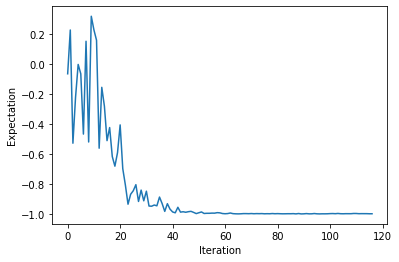

In [6]:
from qiskit.algorithms import NumPyEigensolver

classicalEigenSolver = NumPyEigensolver(k=1) # gets the lowest eigenvalue
result = classicalEigenSolver.compute_eigenvalues(decomposedU)
referenceEigenValueU = np.real(result.eigenvalues.flat[0])

print("The exact ground state energy : {}".format(referenceEigenValueU))
result = vqe.run()
print("The estimated ground state energy from VQE algorithm : {}".format(result.fun))
print("Iteration count for convergence : {}".format(result.nfev))
print("Measurement shot count per iteration: {}".format(vqe.shots))
print("Optimizer {} tolerance: {}".format(vqe.optimizer, vqe.tol))

We can also see the final ansatz with its optimized parameters with ```draw()``` function.

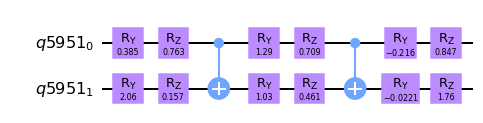

In [7]:
vqe.draw(output='mpl')

Let's now try VQE with a real molecule Hamiltonian.

### Molecule Setup

The hydrogen molecule (H$_2$) at the equilibrium bond length (0.735 Angstrom) will be used. In order to set up the molecular Hamiltonian one has to get the one- and two-electron integrals from a computational chemistry driver (PySCF in this case). The information from the driver is saved in the ``molecule`` object. Then the Fermionic Hamiltonian is mapped to the qubit Hamiltonian using the ``parity`` mapping type as it further reduces the problem size.

In [8]:
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.operators.legacy.op_converter import to_weighted_pauli_operator

driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735',
                     unit=UnitsType.ANGSTROM,
                     basis='sto3g')
molecule = driver.run()
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)

# Build the qubit operator, which is the input to the VQE algorithm
map_type = 'PARITY'
qubitOp = ferOp.mapping(map_type)
qubitOp = Z2Symmetries.two_qubit_reduction(to_weighted_pauli_operator(qubitOp), num_particles)
num_qubits = qubitOp.num_qubits

Let's see how our Hamiltonian looks as matrix and pauli sum operator. 

In [9]:
H = qubitOp.to_opflow().to_matrix()
decomposedH = decomposeHamiltonian(H)
print("Hamiltonian Matrix: \n{}\n".format(H))
print("Decomposed Hamiltonian: \n{}".format(decomposedH))

Hamiltonian Matrix: 
[[-1.06365335+0.j  0.        +0.j  0.        +0.j  0.1809312 +0.j]
 [ 0.        +0.j -1.83696799+0.j  0.1809312 +0.j  0.        +0.j]
 [ 0.        +0.j  0.1809312 +0.j -0.24521829+0.j  0.        +0.j]
 [ 0.1809312 +0.j  0.        +0.j  0.        +0.j -1.06365335+0.j]]

Decomposed Hamiltonian: 
-1.05237324577286 * II
+ 0.39793742484317907 * IZ
+ 0.1809311997842313 * XX
- 0.39793742484317907 * ZI
- 0.01128010425623538 * ZZ


Now we can again initialize our VQE instance and compute analytical ground state energy.

In [10]:
vqeH2 = VQE(H)

result = classicalEigenSolver.compute_eigenvalues(decomposedH)
referenceEigenValueH = np.real(result.eigenvalues.flat[0])

The exact ground state energy : -1.8572750302023822
The estimated ground state energy from VQE algorithm : -1.851117484631565
Iteration count for convergence : 118
Measurement shot count per iteration: 8192
Optimizer COBYLA tolerance: 0.001


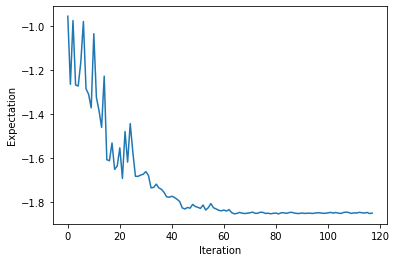

In [11]:
print("The exact ground state energy : {}".format(referenceEigenValueH))
result = vqeH2.run()
print("The estimated ground state energy from VQE algorithm : {}".format(result.fun))
print("Iteration count for convergence : {}".format(result.nfev))
print("Measurement shot count per iteration: {}".format(vqeH2.shots))
print("Optimizer {} tolerance: {}".format(vqeH2.optimizer, vqeH2.tol))

Ansatz with parameters : 
[ 2.04413384  0.2882832   2.90870521  1.35194768  0.38237203 -0.24108451
  1.65190948  1.78248712  1.26511828 -0.10662816  0.21347281  1.01279414]


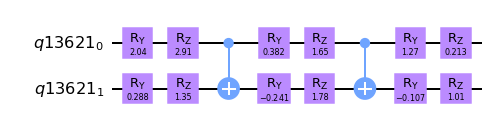

In [12]:
print("Ansatz with parameters : \n{}".format(result.x))
vqeH2.draw(output='mpl')

We demonstrate the calculation of the ground state energy for LiH at various interatomic distances. A driver for the molecule must be created at each such distance. Note that in this experiment, to reduce the number of qubits used, we freeze the core and remove two unoccupied orbitals. First, we define a function that takes an interatomic distance and returns the appropriate qubit operator, $H$, as well as some other information about the operator.

Reference: https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [13]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

I selected 90 angstrom for this distance which is normally too big, but for the sake of run time and qasm simulator measurement errors I used this to simplify Hamiltonian $H$ little bit.

That's because in each iteration there is $shots$ times measurements for each pauli string. Since I don't have access to physical quantum devices to parallelize this process (let's assume there will be 100 iterations and there is also 100 pauli strings in Hamiltonian, and if we are using defaults shots count this would mean 8192 shots. In the end we would need to measure circuit $100_{iteration} \times 100_{paulis} \times 8192_{shots}$ measurements in simulator which is too much), this would take too much time and we are using qasm simulator which is a noisy simulator. With this many measurements there would be too much error which we would be end up in a state we cannot say results are acceptable.

In [14]:
qubitOp, num_particlesLiH, num_spin_orbitalsLiH, shiftLiH = get_qubit_op(90)

In [15]:
decomposdHliH = decomposeHamiltonian(qubitOp.to_opflow().to_matrix())
realQubitOp09A, _, _, _ = get_qubit_op(0.9)
print("0.9 Angstrom seperation hamiltonian : \n{}".format(realQubitOp09A.to_opflow()))

0.9 Angstrom seperation hamiltonian : 
SummedOp([
  -0.24856837156134437 * IIII,
  -0.08833220380647144 * IIIZ,
  0.0004776020581887142 * IIZX,
  -0.0004776020581887142 * IIIX,
  0.0040652294678845445 * IIXX,
  -0.0040652294678845445 * IIYY,
  -0.19804225548931706 * IIZZ,
  0.020638324780023268 * IIXZ,
  0.020638324780023268 * IIXI,
  0.38843443559063723 * IIZI,
  0.08833220380647139 * IZII,
  -0.00047760205818871376 * ZXII,
  -0.00047760205818871376 * IXII,
  0.004065229467884564 * XXII,
  -0.004065229467884564 * YYII,
  -0.1980422554893171 * ZZII,
  -0.020638324780023275 * XZII,
  0.020638324780023275 * XIII,
  -0.3884344355906373 * ZIII,
  -0.13097539918608767 * IZIZ,
  0.00912928952964647 * IZZX,
  -0.00912928952964647 * IZIX,
  0.040357126775294946 * IZXX,
  -0.040357126775294946 * IZYY,
  0.00912928952964647 * IXIZ,
  0.00912928952964647 * ZXIZ,
  -0.0023216284299958203 * IXZX,
  -0.0023216284299958203 * ZXZX,
  0.0023216284299958203 * IXIX,
  0.0023216284299958203 * ZXIX,
  -0.0

In [16]:
print("90 Angstrom separation Hamiltonian\n{}".format(decomposdHliH))

90 Angstrom separation Hamiltonian
-0.14942040605194504 * IIII
- 0.10959592319891784 * IIIZ
+ 0.019478493558969828 * IIZI
- 0.16002186584597225 * IIZZ
+ 0.01522601233826496 * IXIX
- 0.01522601233826496 * IXZX
+ 0.10959592319891788 * IZII
- 0.07056468939034871 * IZIZ
+ 0.001469922950350963 * IZZI
- 0.07140433768490762 * IZZZ
- 0.019478493558969828 * ZIII
+ 0.0014699229503509423 * ZIIZ
- 0.19365148597997436 * ZIZI
+ 0.001469817273499728 * ZIZZ
+ 0.01522601233826496 * ZXIX
- 0.01522601233826496 * ZXZX
- 0.16002186584597228 * ZZII
+ 0.07140433768490762 * ZZIZ
- 0.0014698172734997211 * ZZZI
+ 0.07823637778985229 * ZZZZ


In [17]:
vqeLiH = VQE(decomposdHliH)

result = classicalEigenSolver.compute_eigenvalues(decomposdHliH)
referenceEigenValueHliH = np.real(result.eigenvalues.flat[0])

Block below can take quite some time since it has more pauli strings as decomposed hamiltonian.

The exact ground state energy : -7.78207135029129
The estimated ground state energy from VQE algorithm : -7.774685440301783
Iteration count for convergence : 230
Measurement shot count per iteration: 8192
Optimizer COBYLA tolerance: 0.001


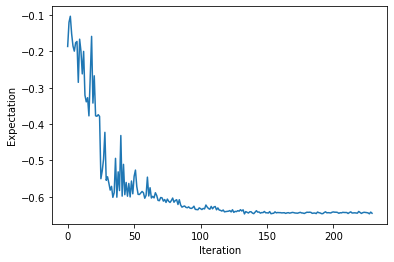

In [18]:
print("The exact ground state energy : {}".format(referenceEigenValueHliH + shiftLiH))
result = vqeLiH.run()
print("The estimated ground state energy from VQE algorithm : {}".format(result.fun + shiftLiH))
print("Iteration count for convergence : {}".format(result.nfev))
print("Measurement shot count per iteration: {}".format(vqeLiH.shots))
print("Optimizer {} tolerance: {}".format(vqeLiH.optimizer, vqeLiH.tol))

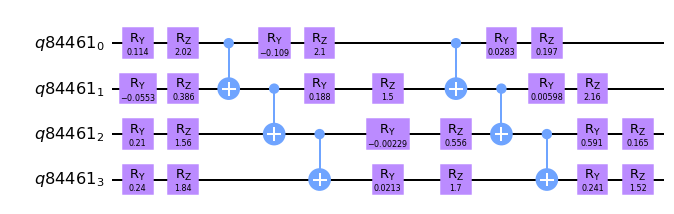

In [19]:
vqeLiH.draw(output="mpl")

# qubit-ADAPT-VQE

In [20]:
from VQEs.ADAPTVQE import ADAPTVQE

In [21]:
adaptvqeU = ADAPTVQE(decomposedH, verbose=True, gradientThreshold=5*1e-2)

In [22]:
minEigenValue, finalCircuit, parameters = adaptvqeU.run()
print("The exact ground state energy : {}".format(referenceEigenValueU))
print("The estimated ground state energy from VQE algorithm : {}".format(minEigenValue))
print("Measurement shot count per iteration: {}".format(adaptvqeU.shots))
print("Optimizer {} tolerance: {}".format(adaptvqeU.optimizer, adaptvqeU.tol))

 Iteration: 1 
Gradient of operator YZ is (0.00399626493261146+0j) 
Gradient of operator IY is (0.005844213266519461+0j) 
Selected operator IY with max gradient 0.005844213266519461 
Eigenvalue : -1.0626501671758037 


 Iteration: 2 
Gradient of operator YZ is (0.014985993497293126+0j) 
Gradient of operator IY is (-0.011472763451874427+0j) 
Selected operator YZ with max gradient 0.014985993497293126 
Max gradient 0.014985993497293126 is smaller than threshold 0.05, terminating algorithm!

The exact ground state energy : -1.0000000000000002
The estimated ground state energy from VQE algorithm : -1.0626501671758037
Measurement shot count per iteration: 8192
Optimizer COBYLA tolerance: 0.001


It converges just in 1 iteration and below you can see the ansatz enough to find the tight upper bound for ground state energy.

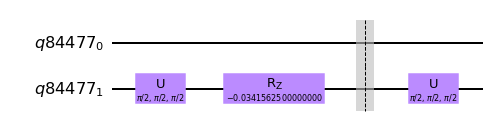

In [27]:
adaptvqeU.draw(output="mpl")

Let's try adapt-vqe with LiH molecule with Hartree Fock initial state:

In [24]:
from qiskit.chemistry.components.initial_states import HartreeFock

qr = QuantumRegister(4)
initial_state = initial_state = HartreeFock(
    num_spin_orbitalsLiH,
    num_particlesLiH,
    qubit_mapping='parity'
)
initial_circuit = initial_state.construct_circuit(mode="circuit", register=qr)

adaptvqeHli = ADAPTVQE(decomposdHliH, verbose=True, gradientThreshold=5*1e-3, maxIterationCount=5, initialState=initial_circuit)

In [25]:
minEigenValue, finalCircuit, parameters = adaptvqeHli.run()
print("The exact ground state energy : {}".format(referenceEigenValueHliH + shiftLiH))
print("The estimated ground state energy from VQE algorithm : {}".format(minEigenValue + shiftLiH))
print("Measurement shot count per iteration: {}".format(adaptvqeHli.shots))
print("Optimizer {} tolerance: {}".format(adaptvqeHli.optimizer, adaptvqeHli.tol))

 Iteration: 1 
Gradient of operator YZZZ is (0.000815102950379716+0j) 
Gradient of operator IYZZ is (-0.000433922426889853+0j) 
Gradient of operator IIYZ is (8.2427294800492e-05+0j) 
Gradient of operator IYIZ is (-0.00045561854823431+0j) 
Gradient of operator IIIY is (-0.000497509006915281+0j) 
Gradient of operator IIYI is (-0.004991141185792317+0j) 
Selected operator IIYI with max gradient 0.004991141185792317 
Eigenvalue : -0.0896635603907409 


 Iteration: 2 
Gradient of operator YZZZ is (-0.000771182556892949+0j) 
Gradient of operator IYZZ is (-0.005467422578812033+0j) 
Gradient of operator IIYZ is (5.279260967558993e-06+0j) 
Gradient of operator IYIZ is (0.004990107909233196+0j) 
Gradient of operator IIIY is (0.00900179812697019+0j) 
Gradient of operator IIYI is (0.003001409097466171+0j) 
Selected operator IIIY with max gradient 0.00900179812697019 
Eigenvalue : -0.6519353508907066 


 Iteration: 3 
Gradient of operator YZZZ is (0.02697944967939219+0j) 
Gradient of operator IYZZ i

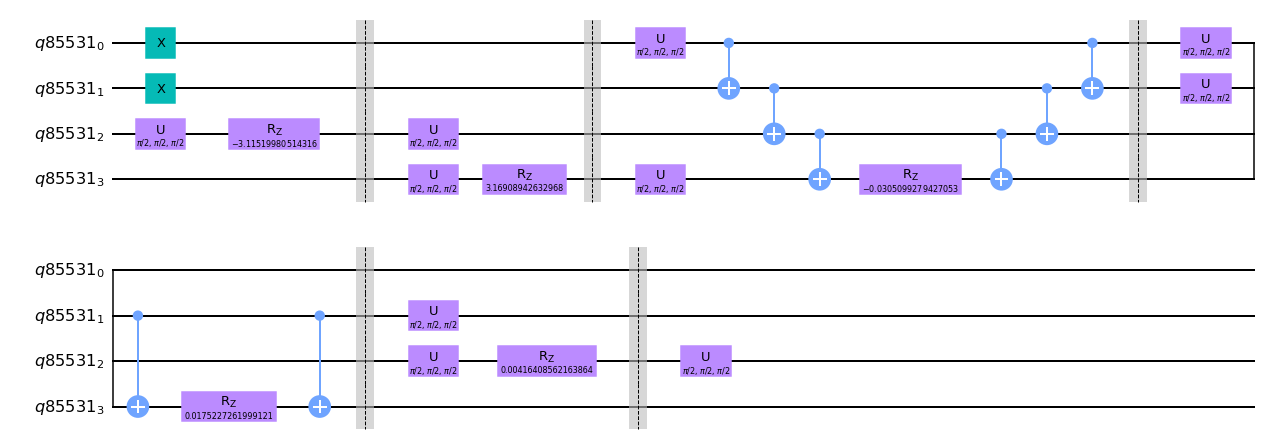

In [26]:
adaptvqeHli.draw(output="mpl")

## Future Improvements
- Try VQEs with real quantum devices with IBM backend.
- qubit-ADAPT-VQE uses complete minimal pool, but in the first iteration even if we start from Hartree Fock state there is a chance of gradient $\langle \psi | [H, \hat{A}] | \psi \rangle $ gives 0(practically is not zero but smaller than threshold) for all pool operators depending on hamiltonian. We can try to start from different initial states $ | \psi \rangle$ to overcome this, I used a simple workaround such as even if the gradients are below threshold in the first iteration, I added the operator with maximum gradient norm to ansatz to make it possible to grow more.

- As you can see in the iteration results, even if the norm of the gradient is bigger than threshold, it doesn't necessarily improve the eigenvalue estimation. As an improvement, we can hold the eigenvalue estimations and circuits until final iteration and if it doesn't converge until maximum iteration count(circuit depth) we can return the minimum estimation eigenvalue with its ansatz.